# CS4287 Assignment 2 Option 2: Deep Q-Learning for Space Invaders

**Team Members:** [Michael Cronin - 22336842], [Darren Nugent - ID]  
**Code Executes to End:** Yes  
**References:** 
- Mnih, V., et al. (2015). Human-level control through deep reinforcement learning. Nature, 518(7540), 529-533.
- van Hasselt, H., et al. (2016). Deep Reinforcement Learning with Double Q-learning. AAAI.

## 1. Why Reinforcement Learning for Space Invaders

Space Invaders requires an agent to make sequential decisions in a dynamic environment where actions have delayed consequences. Reinforcement Learning is the appropriate paradigm for several reasons:

**Sequential Decision Making:** The game requires planning over time - positioning to avoid alien fire while targeting specific aliens for maximum points. RL naturally handles this through its framework of states, actions, and cumulative rewards.

**Trial and Error Learning:** Like a human player, an RL agent learns through interaction with the game environment. It discovers that shooting aliens yields rewards while getting hit ends the episode, without requiring explicit programming of these rules.

**High-Dimensional Visual Input:** The game state is represented as 210×160 RGB images. Deep Q-Networks combine deep learning's ability to process high-dimensional inputs with RL's sequential decision-making framework.

**Delayed Rewards:** Strategic decisions like preserving shields or targeting the mystery ship require understanding delayed consequences - a core strength of RL's reward accumulation over time.

**Dynamic Difficulty:** As aliens are destroyed, the remaining ones speed up. RL agents continuously update their policy based on the current state, naturally adapting to this increasing difficulty.

## 2. The Gymnasium Environment: Space Invaders

### Environment Specification
- **Environment ID:** ALE/SpaceInvaders-v5
- **Observation Space:** Box(0, 255, (210, 160, 3), uint8) - RGB frames
- **Action Space:** Discrete(6)
- **Lives:** 3 per episode

### Action Space
Space Invaders provides 6 discrete actions:

| Action ID | Action Name | Description |
|-----------|-------------|-------------|
| 0 | NOOP | No operation |
| 1 | FIRE | Shoot while stationary |
| 2 | RIGHT | Move right |
| 3 | LEFT | Move left |
| 4 | RIGHTFIRE | Move right and shoot |
| 5 | LEFTFIRE | Move left and shoot |

### Reward Structure
Points are awarded for destroying aliens, with higher rows worth more:

| Target | Points |
|--------|--------|
| Bottom row aliens | 10 |
| Second row | 20 |
| Third row | 30 |
| Top row aliens | 40 |
| Mystery ship (UFO) | 50-200 (random) |

### Role in Training
The environment provides 210×160×3 RGB observations at each timestep. These raw frames are preprocessed to 84×84 grayscale images and stacked in groups of 4 to provide temporal information about motion and velocity. The reward signal guides the agent's policy optimization through the Q-learning algorithm.

In [7]:
!pip install ale_py
!pip install gymnasium[atari]
!pip install matplotlib

In [8]:
import ale_py
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt


# Create the envirnment
gym.register_envs(ale_py)
env = gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array')

In [9]:
# Environment analysis
obs, info = env.reset()

print(f"OBSERVATION SPACE")
print(f"Shape: {obs.shape}")
print(f"Data type: {obs.dtype}")
print(f"Min value: {obs.min()}, Max value: {obs.max()}")
print(f"Total pixels: {np.prod(obs.shape):,}")

print(f"\nACTION SPACE")
print(f"Type: {env.action_space}")
print(f"Number of actions: {env.action_space.n}")

OBSERVATION SPACE
Shape: (210, 160, 3)
Data type: uint8
Min value: 0, Max value: 181
Total pixels: 100,800

ACTION SPACE
Type: Discrete(6)
Number of actions: 6


In [10]:
# See what each action does
action_meanings = env.unwrapped.get_action_meanings()
for i, action in enumerate(action_meanings):
    print(f"Action {i}: {action}")

Action 0: NOOP
Action 1: FIRE
Action 2: RIGHT
Action 3: LEFT
Action 4: RIGHTFIRE
Action 5: LEFTFIRE


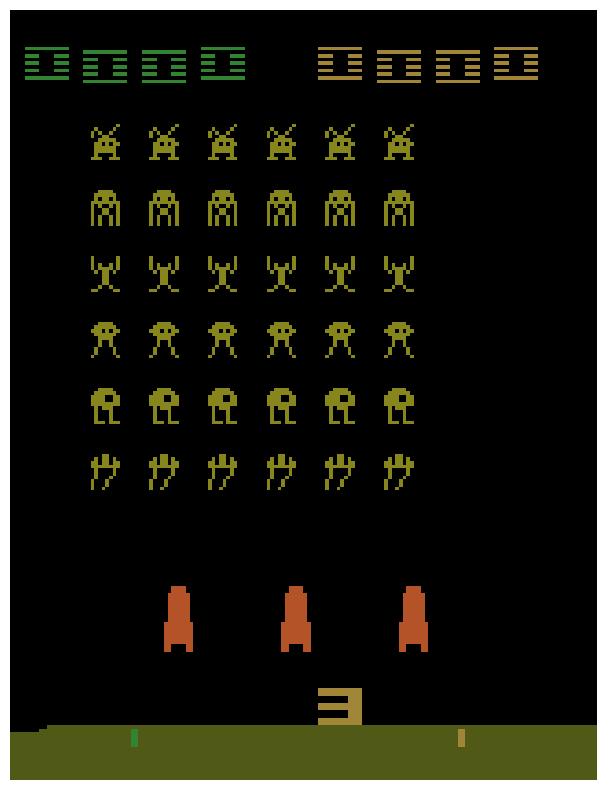

In [11]:
# Visulaise initial state
plt.figure(figsize=(8, 10))
plt.imshow(obs)
plt.axis('off')
plt.show()

In [12]:
env.close()

## 3. Implementation

### 3.1 Data Preprocessing

Raw Atari frames are 210×160×3 RGB images, which is computationally expensive and contains unnecessary information. Our preprocessing pipeline applies the following transformations:

1. **Cropping:** Remove score display and ground (rows 20-195), reducing visual noise
2. **Grayscale conversion:** Reduce from 3 channels to 1 (color not needed for gameplay)
3. **Resize:** Downsample to 84×84 for computational efficiency
4. **Normalization:** Scale pixel values from [0, 255] to [0, 1]
5. **Frame stacking:** Stack 4 consecutive frames to capture motion and velocity information

This reduces the input from 100,800 values per frame to 7,056 values per frame, while the 4-frame stack provides temporal context that allows the network to perceive movement.

In [13]:
!pip install opencv-python
!pip install torch

In [14]:
import gymnasium as gym
import numpy as np
import cv2
from collections import deque

class SpaceInvadersPreprocessor(gym.Wrapper):
    def __init__(self, env, frame_stack=4, im_size=84):
        super().__init__(env)
        self.frame_stack = frame_stack
        self.im_size = im_size
        self.frames = deque(maxlen=frame_stack)
        
        self.observation_space = gym.spaces.Box(
            low=0.0,
            high=1.0,
            shape=(frame_stack, im_size, im_size),
            dtype=np.float32
        )
    
    def preprocess_frame(self, frame):
        # Crop, grayscale, resize, normalize
        cropped = frame[20:195, :]
        gray = cv2.cvtColor(cropped, cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray, (self.im_size, self.im_size), 
                            interpolation=cv2.INTER_AREA)
        normalized = resized.astype(np.float32) / 255.0
        return normalized
    
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        processed = self.preprocess_frame(obs)
        
        for _ in range(self.frame_stack):
            self.frames.append(processed)
        
        return np.array(self.frames, dtype=np.float32), info
    
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        processed = self.preprocess_frame(obs)
        self.frames.append(processed)
        
        return np.array(self.frames, dtype=np.float32), reward, terminated, truncated, info


# Quick test
env = gym.make('ALE/SpaceInvaders-v5')
env = SpaceInvadersPreprocessor(env)
state, _ = env.reset()
print(f"State shape: {state.shape}, range: [{state.min():.2f}, {state.max():.2f}]")
env.close()

State shape: (4, 84, 84), range: [0.00, 0.52]


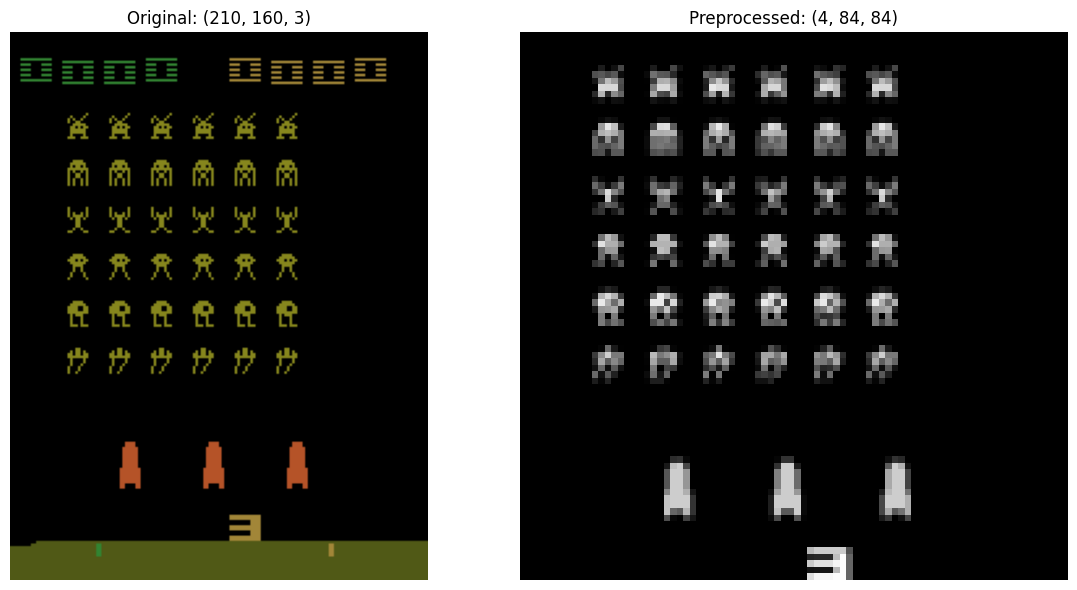

Original: (210, 160, 3), dtype=uint8, range=[0, 181]
Preprocessed: (4, 84, 84), dtype=float32, range=[0.00, 0.52]


In [15]:
import matplotlib.pyplot as plt
import gymnasium as gym

# Create environments
env_orig = gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array')
env_wrap = SpaceInvadersPreprocessor(gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array'))

# Get frames
orig_frame, _ = env_orig.reset(seed=42)
preprocessed, _ = env_wrap.reset(seed=42)

# Take a few steps to see actual gameplay
for _ in range(15):
    orig_frame, _, _, _, _ = env_orig.step(1)  # FIRE action
    preprocessed, _, _, _, _ = env_wrap.step(1)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(orig_frame)
ax1.set_title(f'Original: {orig_frame.shape}')
ax1.axis('off')

ax2.imshow(preprocessed[0], cmap='gray')  # Show first frame from stack
ax2.set_title(f'Preprocessed: {preprocessed.shape}')
ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"Original: {orig_frame.shape}, dtype={orig_frame.dtype}, range=[{orig_frame.min()}, {orig_frame.max()}]")
print(f"Preprocessed: {preprocessed.shape}, dtype={preprocessed.dtype}, range=[{preprocessed.min():.2f}, {preprocessed.max():.2f}]")

env_orig.close()
env_wrap.close()

### 3.2 Network Architecture

The DQN follows the architecture from Mnih et al. (2015):

**Convolutional Layers:**
- Conv1: 32 filters, 8×8 kernel, stride 4 → extracts low-level features (edges, shapes)
- Conv2: 64 filters, 4×4 kernel, stride 2 → mid-level features (alien patterns, shields)
- Conv3: 64 filters, 3×3 kernel, stride 1 → high-level features (spatial relationships)

**Fully Connected Layers:**
- FC1: 3136 → 512 neurons with ReLU activation
- FC2: 512 → 6 neurons (Q-values for each action)

The convolutional layers extract spatial features from the stacked frames, while the fully connected layers map these features to action values. ReLU activations introduce non-linearity, allowing the network to learn complex policies.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, n_actions=6):
        super(DQN, self).__init__()
        
        # Conv layers
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        # FC layers
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, n_actions)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)


# Test it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DQN(n_actions=6).to(device)

# Test with dummy input (batch of 1, 4 frames, 84x84)
test_input = torch.randn(1, 4, 84, 84).to(device)
output = model(test_input)
print(f"Input: {test_input.shape}, Output: {output.shape}")
print(f"Running on: {device}")

Input: torch.Size([1, 4, 84, 84]), Output: torch.Size([1, 6])
Running on: cuda


In [17]:
import random
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            torch.FloatTensor(np.array(states)),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(np.array(next_states)),
            torch.FloatTensor(dones)
        )
    
    def __len__(self):
        return len(self.buffer)


# Test
buffer = ReplayBuffer(capacity=1000)
buffer.push(np.random.rand(4, 84, 84), 2, 10, np.random.rand(4, 84, 84), False)
print(f"Buffer size: {len(buffer)}")

Buffer size: 1


In [ ]:
class DQNAgent:
    def __init__(self, n_actions=6, double_dqn=False):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_actions = n_actions
        self.double_dqn = double_dqn  # Toggle for Double DQN
        
        # Networks
        self.online_net = DQN(n_actions).to(self.device)
        self.target_net = DQN(n_actions).to(self.device)
        self.target_net.load_state_dict(self.online_net.state_dict())
        
        # Training
        self.optimizer = optim.Adam(self.online_net.parameters(), lr=1e-4)
        self.replay_buffer = ReplayBuffer(capacity=100000)
        
        # Hyperparameters
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995
        self.batch_size = 32
        self.target_update_freq = 1000
        self.steps = 0
    
    def choose_action(self, state, training=True):
        # Epsilon-greedy
        if training and random.random() < self.epsilon:
            return random.randrange(self.n_actions)
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.online_net(state_tensor)
            return q_values.argmax().item()
    
    def train_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return None
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)
        
        # Current Q values
        current_q = self.online_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Target Q values
        with torch.no_grad():
            if self.double_dqn:
                # Double DQN: online network selects, target network evaluates
                next_actions = self.online_net(next_states).argmax(1, keepdim=True)
                next_q = self.target_net(next_states).gather(1, next_actions).squeeze(1)
            else:
                # Standard DQN: target network does both
                next_q = self.target_net(next_states).max(1)[0]
            
            target_q = rewards + self.gamma * next_q * (1 - dones)
        
        # Compute loss and update
        loss = F.smooth_l1_loss(current_q, target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_net.parameters(), max_norm=10)
        self.optimizer.step()
        
        # Update target network
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.online_net.state_dict())
        
        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        return loss.item()

In [ ]:
def train(episodes=2000, log_interval=10, double_dqn=False):
    # Setup
    env = gym.make('ALE/SpaceInvaders-v5')
    env = SpaceInvadersPreprocessor(env)
    agent = DQNAgent(n_actions=6, double_dqn=double_dqn)
    
    print(f"Training {'Double DQN' if double_dqn else 'Standard DQN'}")
    
    episode_rewards = []
    losses = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            agent.replay_buffer.push(state, action, reward, next_state, float(done))
            
            loss = agent.train_step()
            if loss is not None:
                losses.append(loss)
            
            state = next_state
            episode_reward += reward
        
        episode_rewards.append(episode_reward)
        
        if episode % log_interval == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_loss = np.mean(losses[-100:]) if losses else 0
            print(f"Episode {episode}, Reward: {episode_reward}, Avg: {avg_reward:.1f}, "
                  f"Loss: {avg_loss:.4f}, Epsilon: {agent.epsilon:.3f}")
        
        if episode % 100 == 0:
            mode = 'double' if double_dqn else 'standard'
            torch.save(agent.online_net.state_dict(), 
                      f'/mnt/user-data/outputs/dqn_{mode}_checkpoint_{episode}.pth')
    
    env.close()
    return episode_rewards, losses


# We can train both for comparison
# rewards_standard, losses_standard = train(episodes=500, double_dqn=False)
# rewards_double, losses_double = train(episodes=500, double_dqn=True)